# Indicator calculations
This notebook contains essential indicators for the analysis of stocks, often used by professionals to evaluate certain courses. Each section pairs a short conceptual description of an indicator with its corresponding implementation. The goal is to keep the explanations concise while making the underlying code easy to maintain, extend or replace. 

Note: ChatGPT was used to suggest indicators 

## What this Notebook contains
- A brief introduction to the purpose and scope of the analysis
- Modular sections, one per indicator
- For each indicator an explanation, concept, formula and typical usage, as well as the sources
- Optional example calculations and visualizations (depending on the indicator)

## Objectives
- Provide a clear and reproducible workflow for computing technical indicators
- Allow quick navigation and understanding of each indicator's theoretical background
- Maintain clear seperation between documentation and code
- Support iterative, development, testing, and extension of indicator logic


# Imports

In [1]:
import pandas as pd

## Simple Moving Average (SMA)

![60e5f3e3a0736d847417ca55_Simple Moving Average.jpg](<attachment:60e5f3e3a0736d847417ca55_Simple Moving Average.jpg>)

In short: The sma is the average price over a specific period. For analytics purposes we use one long sma and one short sma. The long sma describes the trend due to a longer timefrime, while the short sma reacts quicker and displays momentum and sudden market movements. We devide between death- and golden crosses (described in the moving average crossover tab). 

### Calculation

Its calculation is pretty simple and the closing market price of each day (as seen with pd.rolling(window)) and divides it by the window frame (as seen with .mean()) , to get the mean average.

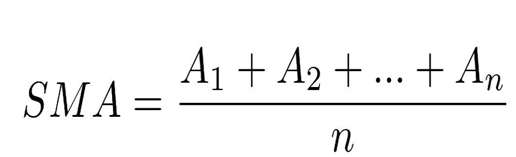

Source:  https://medium.com/analytics-vidhya/sma-short-moving-average-in-python-c656956a08f8

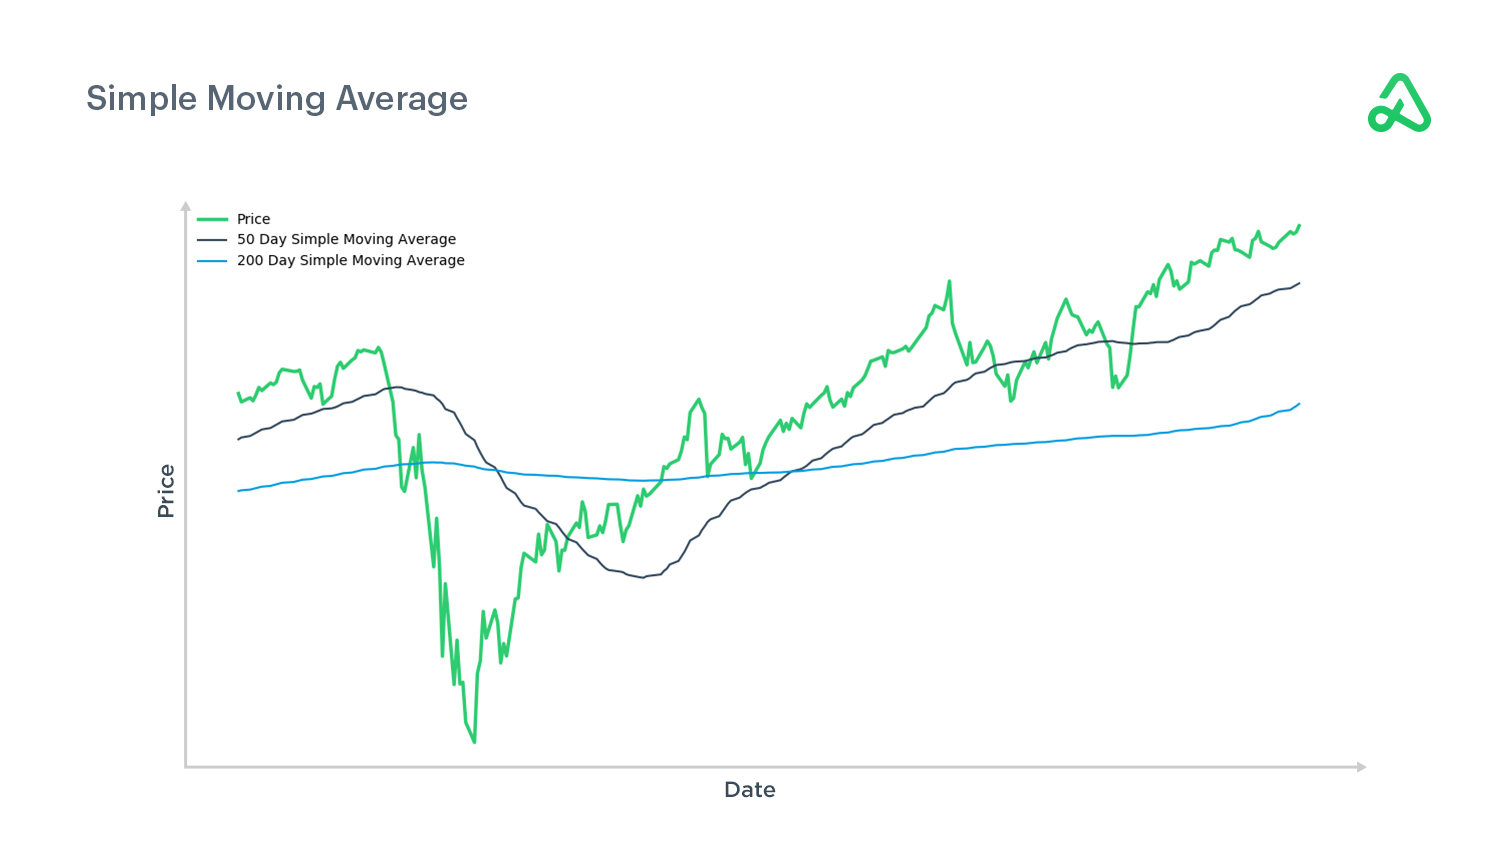

In [2]:
def sma(data, window):
    """Calculate Simple Moving Average (SMA)"""

    # using pandas .rolling() and .mean(), as they are easier
    sma = data['Close'].rolling(window=window).mean()

    return sma

# Exponential moving average (EMA)

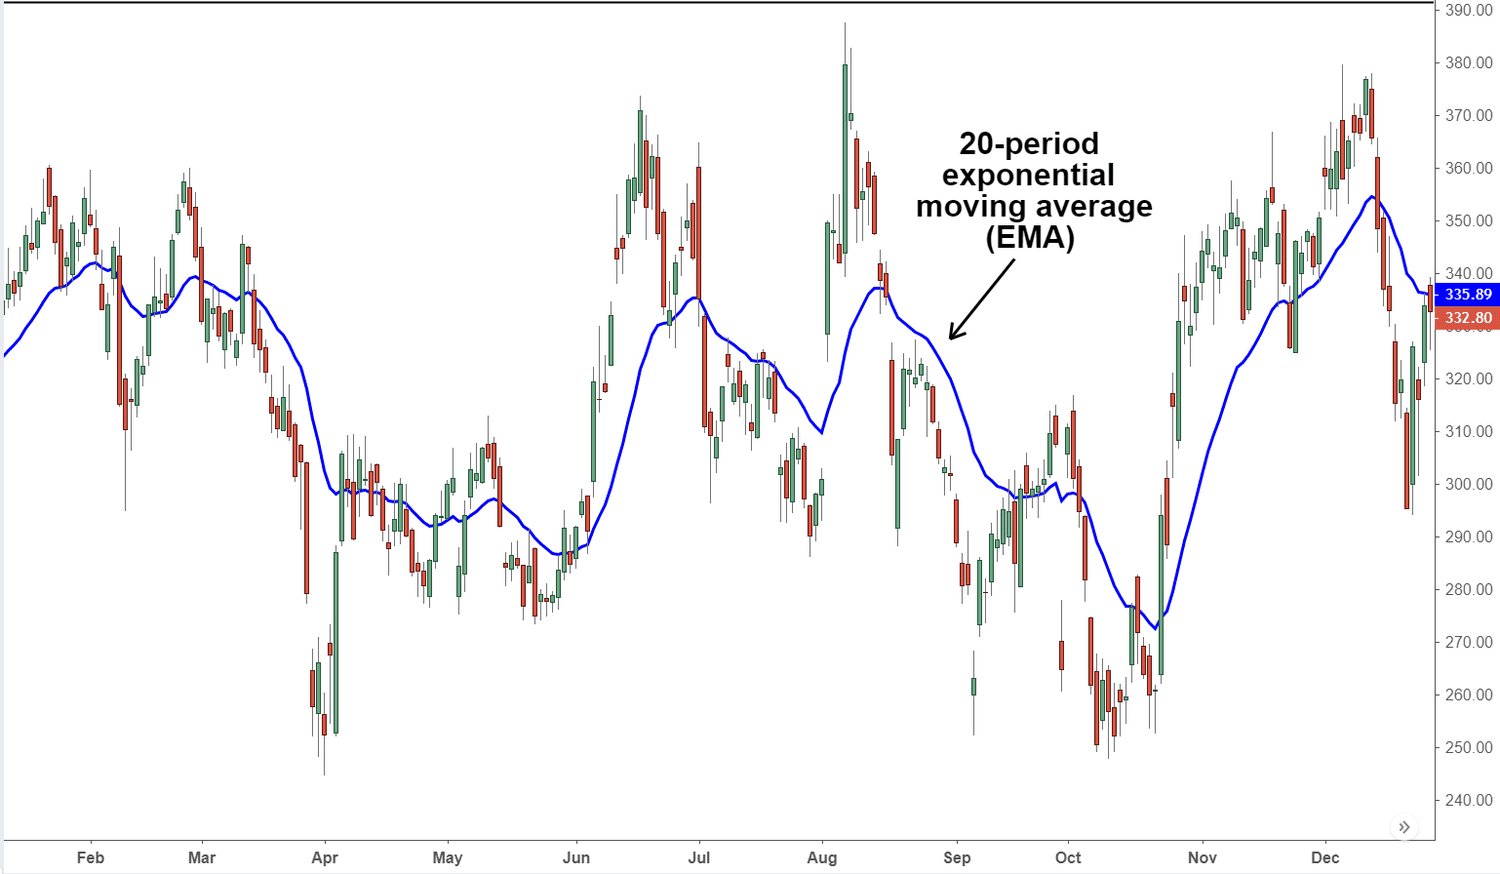

The 'big brother' of the sma. While the analysis works similarly to the sma by comparing a long and short window and finding crossovers, the ema has one distinct difference and advantage: What if a stock suddenly explodes(or drops)? The sma might be too slow to react in time, because each closing date is worth the same in the calculation, so the closing price 100 days ago is just as important as the one today. 

The EMA fixes this by giving an increased weight and therefore importance to more recent dates, which makes it perfect to detect sudden movement. Here we will also look at crossovers, also explained after this section.

### Calculation

For this calculation we use .ewm() by pandas, I attached a link below from their docs.

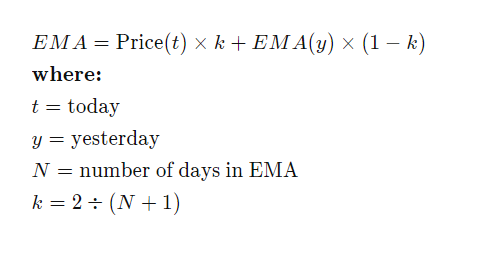

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html



In [3]:
def ema(data, window):
    """Calculate Exponential Moving Average (EMA)"""

    # using pandas .ewm() and .mean(), as they are easier than manual calculation
    ema = data['Close'].ewm(span=window, adjust=False).mean()
    return ema

# Moving average crossovers (both ema and sma)

As mentioned earlier, the most important indicators are often the crossovers. Here we divide between:

- Death Crosses:
Death crosses are usually the biggest indicator to sell a stock. It happens when the short moving average crosses below the long moving average. This means that the overall trend is bigger than momentum and that momentum slowly(or fastly), that means the price is often in a sort of free fall and is expected to drop further after a death cross.

- Golden Crosses:
The opposite of a death cross, it is the absolute hint of buying a stock in most circumstances. A golden cross happens when a short ma crosses above a long ma, so the recent momentum is stronger than a trend and it hints towards a drastic increase of price, due to high momentum.

Here we check for locations in the lists of the ma's, to determine turning points of long and short ma's. A turning point happens when the short ma is for example bigger at .iloc[i-1] but smaller at .iloc[i+1], than the long ma.

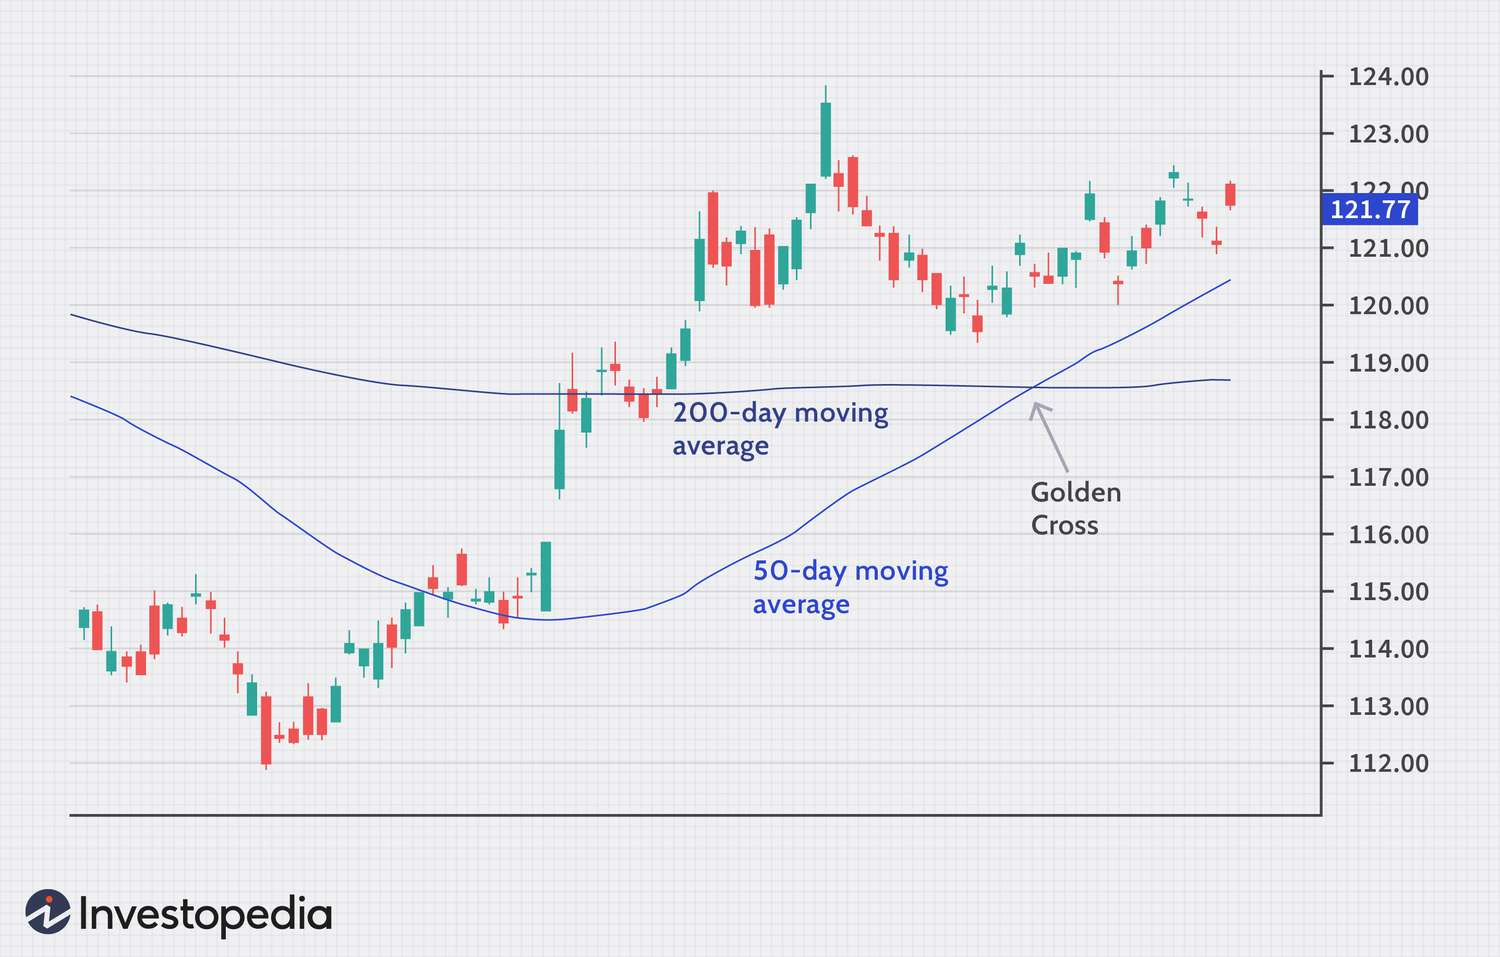

https://www.investopedia.com/terms/g/goldencross.asp

In [4]:
def moving_average_crossover(data, short_ma, long_ma):
    """Calculate Moving Average Crossover Signals"""

    # empty DataFrame to store crossover signals
    crossings = pd.DataFrame()
    crossings_data = []

    # check where short MA crosses long MA and append the type of crossover to the dattaframe along with the date(for plotting)
    for i in range(1, len(data)):
        if i < len(data) - 1:
            if short_ma.iloc[i+1] > long_ma.iloc[i+1] and short_ma.iloc[i-1] <= long_ma.iloc[i-1]:
                crossings_data.append((data.index[i], 'Golden Cross'))

            elif short_ma.iloc[i+1] < long_ma.iloc[i+1] and short_ma.iloc[i-1] >= long_ma.iloc[i-1]:
                crossings_data.append((data.index[i], 'Death Cross'))

            else:
                continue

    if crossings_data:
        crossings = pd.DataFrame(crossings_data, columns=[
                                 'Date', 'Crossover Type']).set_index('Date')

    return crossings['Crossover Type']

# Bollinger bands

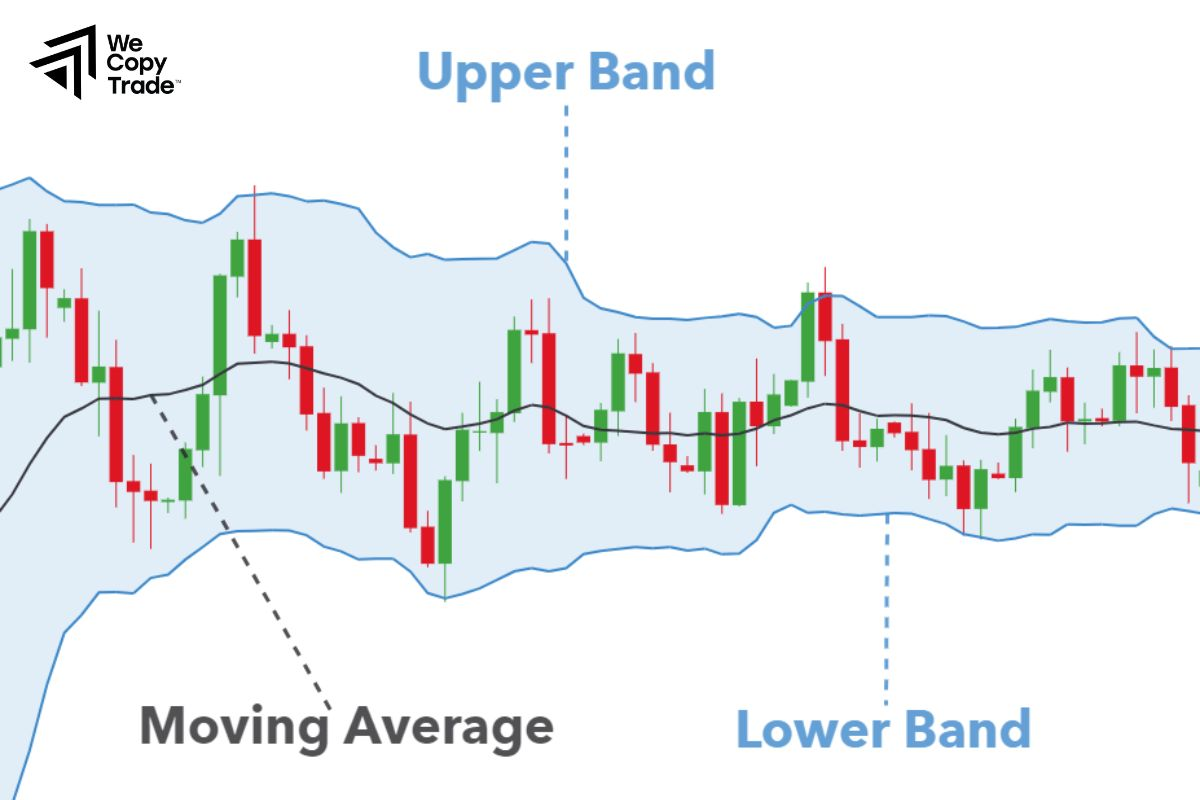


Bollinger bands are a key technical analysis tool for investors. They consist of an upper and lower band, as well as a moving average to determine the center. Generally we expect any stock to move between the upper and lower band. However, whenever we detect it touching either of the two, it is a strong indicator for volatility but also momentum. IF it touches the upper band we can deduct that the momentum is high, but it is very volatile and not very stable.

### Calculation
First we take an SMA (See above) and calculate its standard deviation (Luckily pandas also has a convenient function for us: .std()): <br>
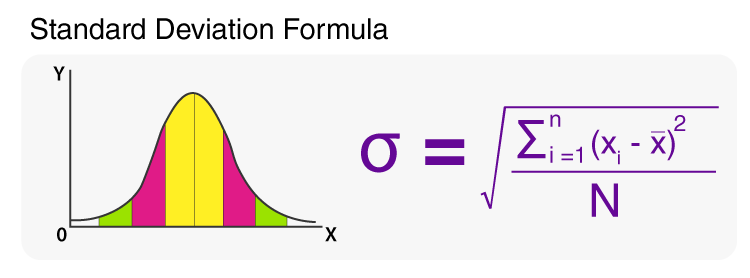

The upper band is two stds above the sma, while the lower band is two stds below the sma (Simply deduct).
https://www.investopedia.com/terms/b/bollingerbands.asp

In [5]:
def bollinger_bands(data, window):
    """Calculate Bollinger Bands"""

    # get sma and std deviation
    sma = data['Close'].rolling(window=window).mean()
    std = data['Close'].rolling(window=window).std()
    # calculate upper and lower bands by adding/subtracting 2*std from sma
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)

    return lower_band, upper_band

# Relative Strength Index (rsi)
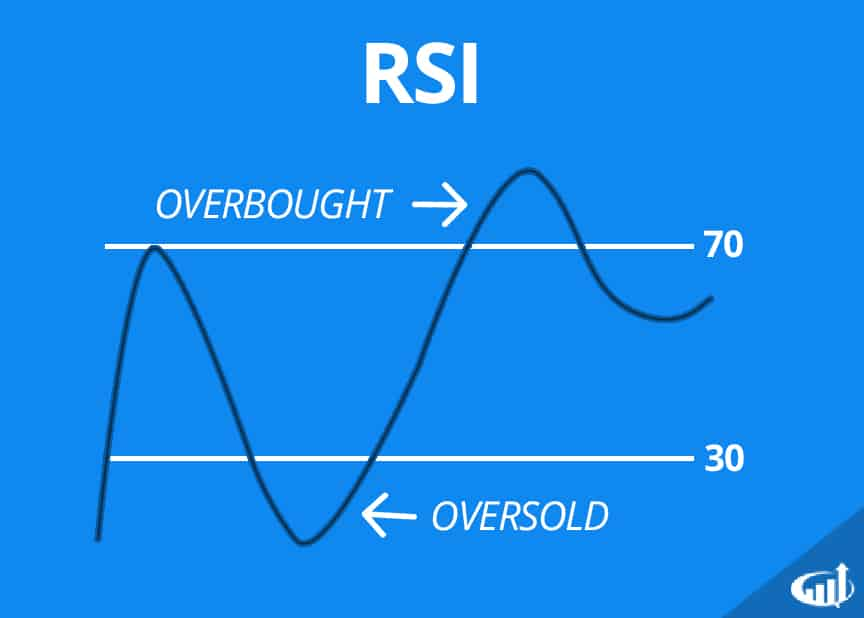

The rsi is a momentum indicator used in analysis. It basically measures the speed and magnitude of recent price changes to detect overbought or oversold conditions. It ranges from 0 - 100.

Typically an rsi of above 70 indicate overbought conditions, while an rsi of below 30 indicate oversold conditions. It can also indicate securities that may be primed for a trend reversal or a corrective pullback in price. 

### Calculation
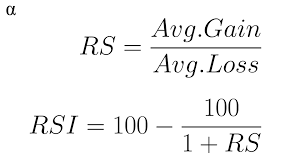

In pandas we use diff() to indicate a delta(general change), calculate the gain wherever the delta is larger than 0 and a loss wherever the delta is smaller than 0 (.where(delta < 0, 0)). The rest is the same as shown above.

https://www.investopedia.com/terms/r/rsi.asp

In [6]:
def rsi(data, window):
    """Calculate Relative Strength Index (RSI)"""

    # calculate price changes
    delta = data['Close'].diff()
    
    # separate gains and losses
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

# Price changes 
Self-explanatory really, we calculate the price change between the first entry of the list and the last one and return the rounded value. 

Price Change Percentage = ((Current Price - Previous Price) / Previous Price) * 100

In [7]:
def price_change(data):
    """Calculate Price Change Percentage"""

    # calculate price change percentage between first and last closing prices
    price_change = (
        (data['Close'].iloc[-1] - data['Close'].iloc[0]) / data['Close'].iloc[0]) * 100
    # round to 2 decimal places
    return price_change.round(2)

# Moving Average Convergence Divergence (MACD)
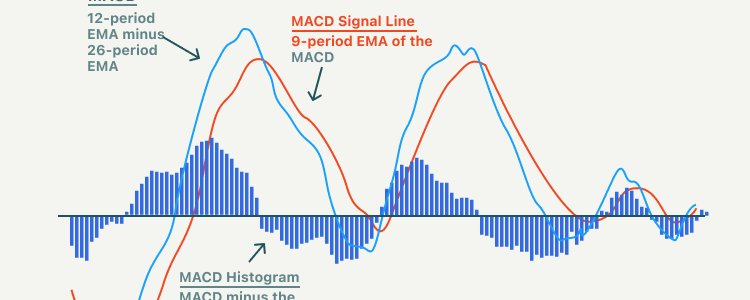 <br>
I know it might sound very complicated but it is basically just an extention to the ema. It helps analysing price trends, momentum and identify entry points. It shows the relationship betwenn two moving averages of a Stock's price.
Generally here we also use crossovers to get buy and sell signals. We are also looking for fast lines crossing above slow lines to catch momentum

# Calculation
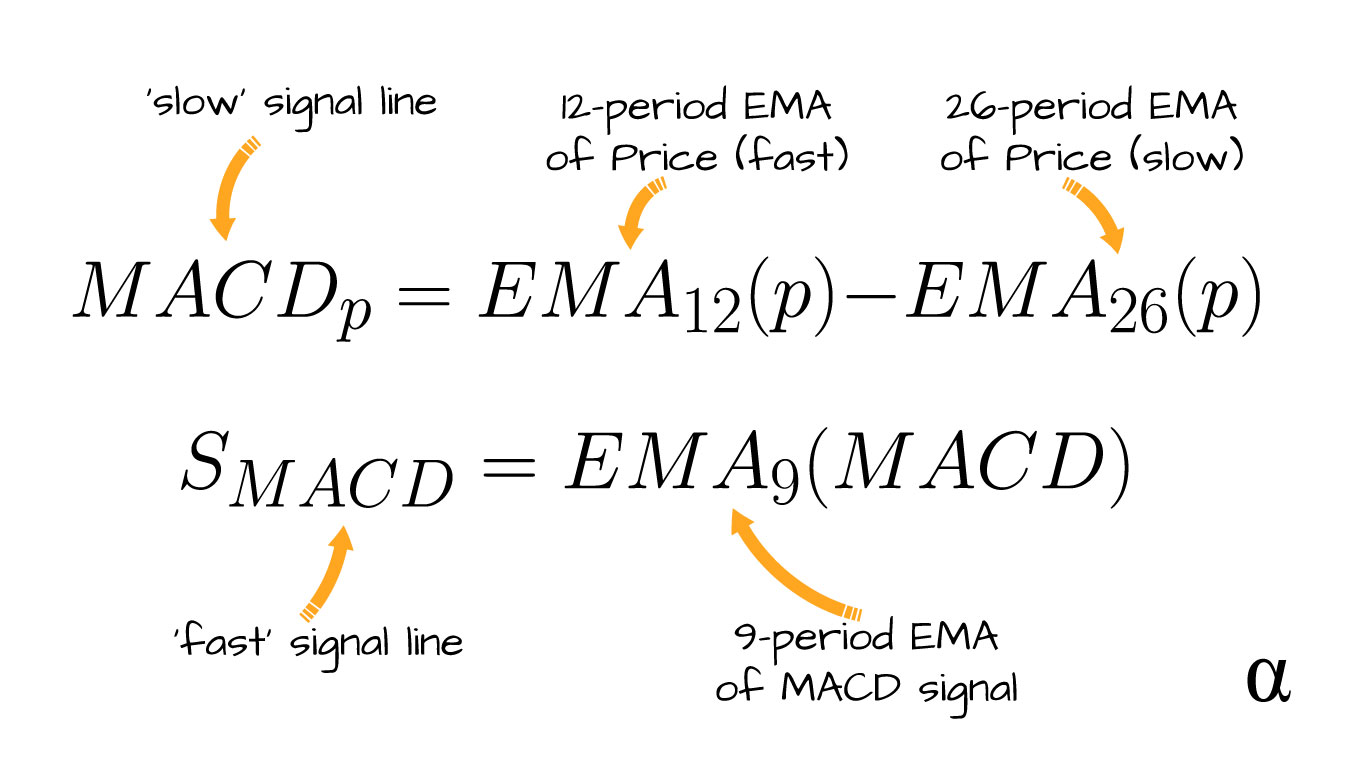
We take an EMA12 and EMA 26, subtract the EMA26 from the EMA12 and calculate a slow moving macd line. Then we calculate the EMA9 of the macd line and get a fast moving signal line.

https://www.investopedia.com/terms/m/macd.asp

In [8]:
def macd(data, short_window=12, long_window=26, signal_window=9):
    """Calculate Moving Average Convergence Divergence (MACD)"""

    # calculate EMA short and long
    ema_short = ema(data, short_window)
    ema_long = ema(data, long_window)
    macd_line = ema_short - ema_long
    # calculate signal line
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

# Average true range(atr)
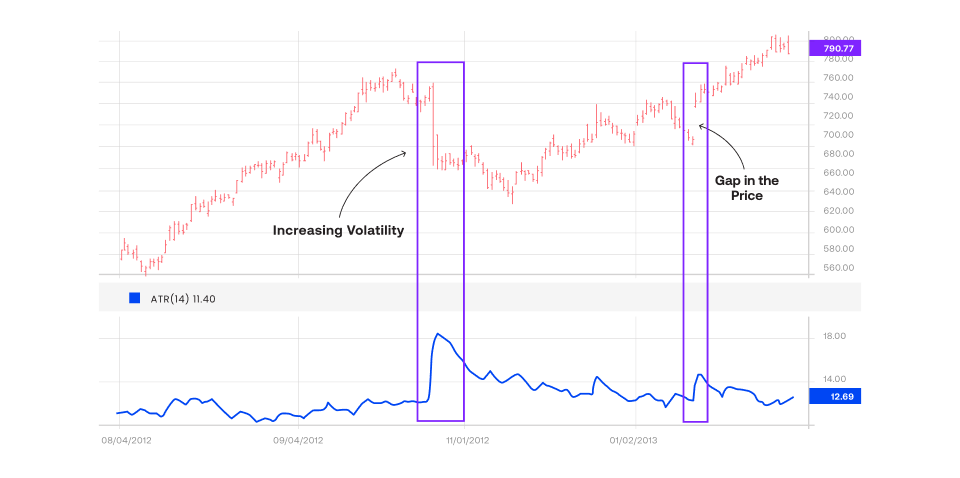 <br>
I was looking for an indicator which could show a sort of 'risk' assessment in percent and atr is the closest we'll get. The atr shows volatility by decomposing the entire range of a price for a certain period. 
As a window we could choose anything but I opted for 14 as the compromise between long- and short-term volatility. ATR measures volatility, taking into account any gaps in the price movement.

### Calculation
Even though the calculation might be the most complicated of the bunch I'll try to make everything understandable

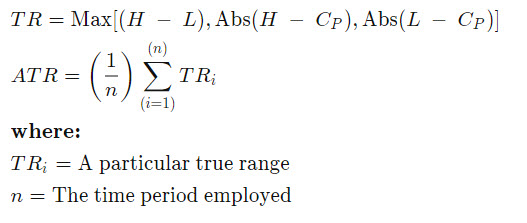

High - Low -> Normal range <br>
High - prevClose -> upward gap <br>
Low - prevClose -> Downward gap <br>

- TR measures the actual price movement including gaps.
- ATR smooths TR into a stable indicator of volatility.
- Higher ATR → more volatility.
- Lower ATR → quieter price action.

Afterwards we scale it by dividing the atr with the max atr and multipliying it by 100, to get a nice percentage each user can work with, instead of using relative values.

https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/atr

In [9]:
def atr(data, window=14):
    """Average true range"""

    # Average true range is an indicator for market volatility and therefore risk

    true_ranges = pd.DataFrame()
    # calculate true range as shown above
    true_ranges['H-L'] = data['High'] - data['Low']
    true_ranges['H-PC'] = abs(data['High'] - data['Close'].shift(1))
    true_ranges['L-PC'] = abs(data['Low'] - data['Close'].shift(1))
    true_range = true_ranges.max(axis=1)

    atr = true_range.rolling(window=window).mean()

    # scale atr to be between 0 and 100 : easier to understand percentages
    atr_scaled = (atr / atr.max()) * 100

    return atr_scaled.iloc[-1]




# Future indicators
 
If desired I will add more indicators in the future but I also want to keep it tidy and not too complicated